In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt

/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_27853/3888494262.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')

NORM_WT_FTRS_INPUT_PATH = output_paths.get('normalize_and_weight_features.csv')

MODEL_INPUT_PATH = output_paths.get("model_output")

In [3]:
FUTURE_PREDS_OUTPUT_PATH = output_paths.get("smoke_impact_model_predictions.csv")

## Future Predictions for Fire Size and Distance from Memphis 

This code processes historical fire data to calculate a 5-year rolling average of total acres burned and average distance, which is used as the basis for future predictions from 2025 to 2050. For each 5-year interval, the most recent rolling average is applied, and then the new data is incorporated into the dataset to update the rolling average, simulating trends over time. The output provides year-by-year predictions that adjust every 5 years based on historical patterns.

In [4]:
fire_data = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

# Group by year and calculate sums and averages for fire size and distance
yearly_fire_data = fire_data.groupby('fire_year').agg(
    total_acres_burned_sum=('total_acres_burned', 'sum'),
    avg_distance=('distance', 'mean')
).reset_index()

# Sort by year for chronological order
yearly_fire_data = yearly_fire_data.sort_values(by='fire_year')

In [5]:
print(yearly_fire_data)

    fire_year  total_acres_burned_sum  avg_distance
0        1964            2.846812e+01    384.142162
1        1965            4.378149e+01    371.279426
2        1966            2.696491e+01    260.843100
3        1967            5.048215e+02    371.508724
4        1968            4.072332e+01    363.429542
5        1969            3.952557e+02    285.092861
6        1970            2.350625e+03    210.041483
7        1971            1.114742e+03    207.752459
8        1972            5.916350e+02    219.768587
9        1973            3.328419e+02    213.031734
10       1974            1.370488e+03    244.264814
11       1975            1.064286e+03    245.898506
12       1976            4.254954e+03    267.141995
13       1977            2.231838e+03    263.460774
14       1978            4.031375e+03    321.191568
15       1979            2.274603e+03    328.034550
16       1980            4.400419e+03    337.184409
17       1981            4.243582e+03    379.948317
18       198

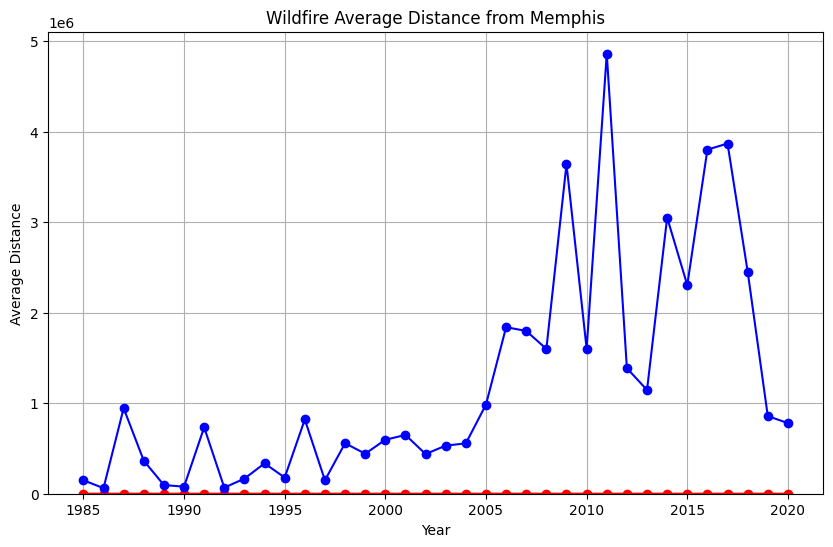

In [7]:
# Filter data to include only years after 1984
filtered_yearly_fire_data = yearly_fire_data[yearly_fire_data['fire_year'] > 1984]

# Plot predicted smoke impact
plt.figure(figsize=(10, 6))
plt.plot(filtered_yearly_fire_data['fire_year'], filtered_yearly_fire_data['avg_distance'], label='Average Distance', linestyle='-', marker='o', color='red')
plt.plot(filtered_yearly_fire_data['fire_year'], filtered_yearly_fire_data['total_acres_burned_sum'], label='Total Acres Burned', linestyle='-', marker='o', color='blue')

# Add titles and labels
plt.title('Wildfire Average Distance from Memphis')
plt.xlabel('Year')
plt.ylabel('Average Distance')
plt.ylim(0, None)  # Set y-axis to start at 0
plt.grid(True)

# Display the plot
plt.show()


In [8]:
# Read the CSV file
df = pd.read_csv(NORM_WT_FTRS_INPUT_PATH)


# Set the variables from the DataFrame values
acres_weight = df.at[0, "acres_weight"]
dist_weight = df.at[0, "dist_weight"]
max_acres_burned = df.at[0, "max_total_acres_burned"]

# Convert to the appropriate data type if needed
acres_weight = float(acres_weight)
dist_weight = float(dist_weight)
max_acres_burned = float(max_acres_burned)


print(f'max_acres_burned: {max_acres_burned}, acres_weight: {acres_weight}, dist_weight: {dist_weight}')

max_distance = 650 

# Normalize and rename the future prediction features
filtered_yearly_fire_data['total_acres_burned_normalized'] = filtered_yearly_fire_data['total_acres_burned_sum'] / max_acres_burned

filtered_yearly_fire_data['distance_normalized'] = filtered_yearly_fire_data['avg_distance'] / max_distance




max_acres_burned: 4859569.981645179, acres_weight: 1.0, dist_weight: 1.0


/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_27853/993739475.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_yearly_fire_data['total_acres_burned_normalized'] = filtered_yearly_fire_data['total_acres_burned_sum'] / max_acres_burned
/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_27853/993739475.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_yearly_fire_data['distance_normalized'] = filtered_yearly_fire_data['avg_distance'] / max_distance


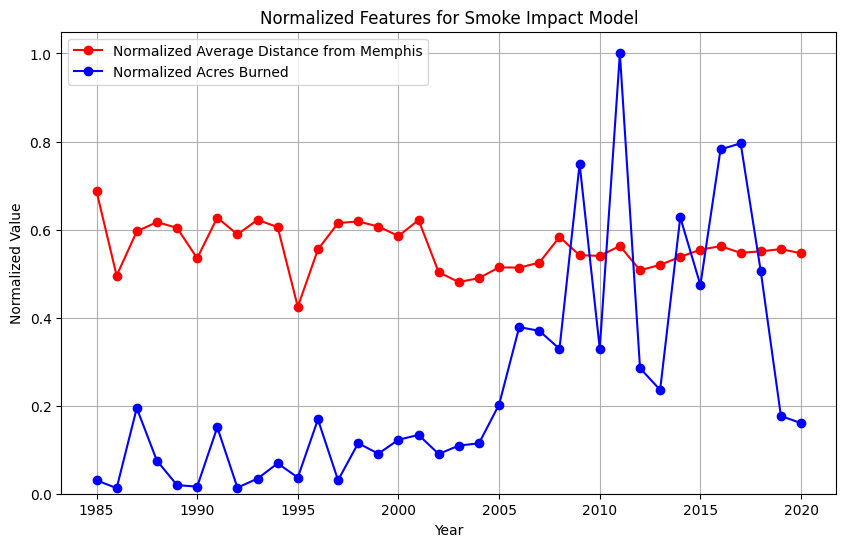

In [9]:
# Plot predicted smoke impact
plt.figure(figsize=(10, 6))
plt.plot(filtered_yearly_fire_data['fire_year'], filtered_yearly_fire_data['distance_normalized'], label='Normalized Average Distance from Memphis', linestyle='-', marker='o', color='red')
plt.plot(filtered_yearly_fire_data['fire_year'], filtered_yearly_fire_data['total_acres_burned_normalized'], label='Normalized Acres Burned', linestyle='-', marker='o', color='blue')

# Add titles and labels
plt.title('Normalized Features for Smoke Impact Model')
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.ylim(0, None)  # Set y-axis to start at 0
plt.grid(True)
plt.legend()
# Display the plot
plt.show()


In [ ]:
# Calculate a 5-year moving average for fire size and distance
filtered_yearly_fire_data['5yr_avg_normalized_acres'] = filtered_yearly_fire_data['total_acres_burned_normalized'].rolling(window=5, min_periods=1).mean()
filtered_yearly_fire_data['5yr_avg_normalized_distance'] = filtered_yearly_fire_data['distance_normalized'].rolling(window=5, min_periods=1).mean()

# Initialize a DataFrame to hold predictions for each year from 2021 to 2050
future_years = range(2021, 2051)
future_predictions = pd.DataFrame({
    'year': future_years,
    'predicted_normalized_total_acres_burned': np.nan,
    'predicted_normalized_avg_distance': np.nan
})

# Copy historical data into a temporary DataFrame to simulate adding future data
temp_data = filtered_yearly_fire_data.copy()

/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_27853/630325862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_yearly_fire_data['5yr_avg_normalized_acres'] = filtered_yearly_fire_data['total_acres_burned_normalized'].rolling(window=5, min_periods=1).mean()
/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_27853/630325862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_yearly_fire_data['5yr_avg_normalized_distance'] = filtered_yearly_fire_data['distance_normaliz

In [11]:
print(temp_data)

    fire_year  total_acres_burned_sum  avg_distance  \
21       1985            1.485882e+05    446.654504   
22       1986            6.154869e+04    321.949288   
23       1987            9.446789e+05    387.160662   
24       1988            3.646471e+05    401.045945   
25       1989            9.559396e+04    392.571150   
26       1990            7.796472e+04    347.641996   
27       1991            7.331953e+05    407.643939   
28       1992            6.715140e+04    382.792261   
29       1993            1.669350e+05    404.341823   
30       1994            3.350621e+05    393.622208   
31       1995            1.789948e+05    275.928324   
32       1996            8.200648e+05    360.662710   
33       1997            1.488227e+05    399.570024   
34       1998            5.576293e+05    402.010244   
35       1999            4.417406e+05    394.506549   
36       2000            5.959007e+05    380.459792   
37       2001            6.491342e+05    404.006933   
38       2

In [ ]:
# Set the 5-year recalculation cycle
cycle_length = 5

    # 'predicted_normalized_total_acres_burned': np.nan,
    # 'predicted_normalized_avg_distance': np.nan

# Loop through each year in the forecast period, applying 5-year recalculations
for i, year in enumerate(future_years):
    # Assign predictions for this year based on the latest 5-year average
    future_predictions.loc[i, 'predicted_normalized_total_acres_burned'] = temp_data['5yr_avg_normalized_acres'].iloc[-1]
    future_predictions.loc[i, 'predicted_normalized_avg_distance'] = temp_data['5yr_avg_normalized_distance'].iloc[-1]

    # Every 5 years, update rolling averages using the latest values
    if (i + 1) % cycle_length == 0:
        # Create a new row for the latest predictions as "historical" data
        new_row = pd.DataFrame({
            'fire_year': [year],
            'total_acres_burned_sum': [future_predictions.loc[i, 'predicted_normalized_total_acres_burned']],
            'avg_distance': [future_predictions.loc[i, 'predicted_normalized_avg_distance']]
        })
        
        # Concatenate the new row to `temp_data`
        temp_data = pd.concat([temp_data, new_row], ignore_index=True)

        # Recalculate the 5-year rolling averages on the updated data
        temp_data['5yr_avg_normalized_acres'] = temp_data['total_acres_burned_normalized'].rolling(window=5, min_periods=1).mean()
        temp_data['5yr_avg_normalized_distance'] = temp_data['distance_normalized'].rolling(window=5, min_periods=1).mean()

# Display the updated predictions with 5-year interval adjustments
print(future_predictions)


    year  predicted_total_acres_burned  predicted_avg_distance
0   2021                  2.351687e+06              359.010931
1   2022                  2.351687e+06              359.010931
2   2023                  2.351687e+06              359.010931
3   2024                  2.351687e+06              359.010931
4   2025                  2.351687e+06              359.010931
5   2026                  2.061966e+06              357.712907
6   2027                  2.061966e+06              357.712907
7   2028                  2.061966e+06              357.712907
8   2029                  2.061966e+06              357.712907
9   2030                  2.061966e+06              357.712907
10  2031                  1.700817e+06              358.135215
11  2032                  1.700817e+06              358.135215
12  2033                  1.700817e+06              358.135215
13  2034                  1.700817e+06              358.135215
14  2035                  1.700817e+06              358

## Future Predictions for Scaled Average Daily Smoke Impact

In [ ]:
# Prepare future prediction data for smoke impact
X_future = future_predictions[['total_acres_burned_weighted', 'distance_weighted']]

### Load the Model

In [136]:
# Load the trained Gradient Boosting model
with open(MODEL_INPUT_PATH, 'rb') as model_file:
    model = pickle.load(model_file)

### Normalize and Weight Future Data

In [ ]:
# # Read the CSV file
# df = pd.read_csv(NORM_WT_FTRS_INPUT_PATH)


# # Set the variables from the DataFrame values
# acres_weight = df.at[0, "acres_weight"]
# dist_weight = df.at[0, "dist_weight"]
# max_acres_burned = df.at[0, "max_total_acres_burned"]

# # Convert to the appropriate data type if needed
# acres_weight = float(acres_weight)
# dist_weight = float(dist_weight)
# max_acres_burned = float(max_acres_burned)


# print(f'max_acres_burned: {max_acres_burned}, acres_weight: {acres_weight}, dist_weight: {dist_weight}')

# max_distance = 650 

# # Normalize and rename the future prediction features
# future_predictions['total_acres_burned_normalized'] = future_predictions['predicted_total_acres_burned'] / max_acres_burned

# future_predictions['distance_normalized'] = future_predictions['predicted_avg_distance'] / max_distance

# future_predictions['total_acres_burned_weighted'] = future_predictions['total_acres_burned_normalized'] * acres_weight
# future_predictions['distance_weighted'] = future_predictions['distance_normalized'] * dist_weight


max_acres_burned: 4859569.981645179, acres_weight: 1.0, dist_weight: 1.0


In [ ]:
# print(future_predictions)

    year  predicted_total_acres_burned  predicted_avg_distance  \
0   2021                  2.351687e+06              359.010931   
1   2022                  2.351687e+06              359.010931   
2   2023                  2.351687e+06              359.010931   
3   2024                  2.351687e+06              359.010931   
4   2025                  2.351687e+06              359.010931   
5   2026                  2.061966e+06              357.712907   
6   2027                  2.061966e+06              357.712907   
7   2028                  2.061966e+06              357.712907   
8   2029                  2.061966e+06              357.712907   
9   2030                  2.061966e+06              357.712907   
10  2031                  1.700817e+06              358.135215   
11  2032                  1.700817e+06              358.135215   
12  2033                  1.700817e+06              358.135215   
13  2034                  1.700817e+06              358.135215   
14  2035  

### Make the model predictions

In [ ]:
# Predict smoke impact for each year using the model
future_predictions['predicted_smoke_impact'] = model.predict(X_future)

# Display the predictions for smoke impact from 2025 to 2050
print(future_predictions[['year', 'predicted_total_acres_burned', 'predicted_avg_distance', 'predicted_smoke_impact']])

    year  predicted_total_acres_burned  predicted_avg_distance  \
0   2021                  2.351687e+06              359.010931   
1   2022                  2.351687e+06              359.010931   
2   2023                  2.351687e+06              359.010931   
3   2024                  2.351687e+06              359.010931   
4   2025                  2.351687e+06              359.010931   
5   2026                  2.061966e+06              357.712907   
6   2027                  2.061966e+06              357.712907   
7   2028                  2.061966e+06              357.712907   
8   2029                  2.061966e+06              357.712907   
9   2030                  2.061966e+06              357.712907   
10  2031                  1.700817e+06              358.135215   
11  2032                  1.700817e+06              358.135215   
12  2033                  1.700817e+06              358.135215   
13  2034                  1.700817e+06              358.135215   
14  2035  

In [141]:
future_predictions.to_csv(FUTURE_PREDS_OUTPUT_PATH, index=False)

print(f"Future smoke impact predictions saved to {FUTURE_PREDS_OUTPUT_PATH}")

Future smoke impact predictions saved to final-output/smoke_impact_estimate_mdl_future_prediction.csv


## Prediction Graph

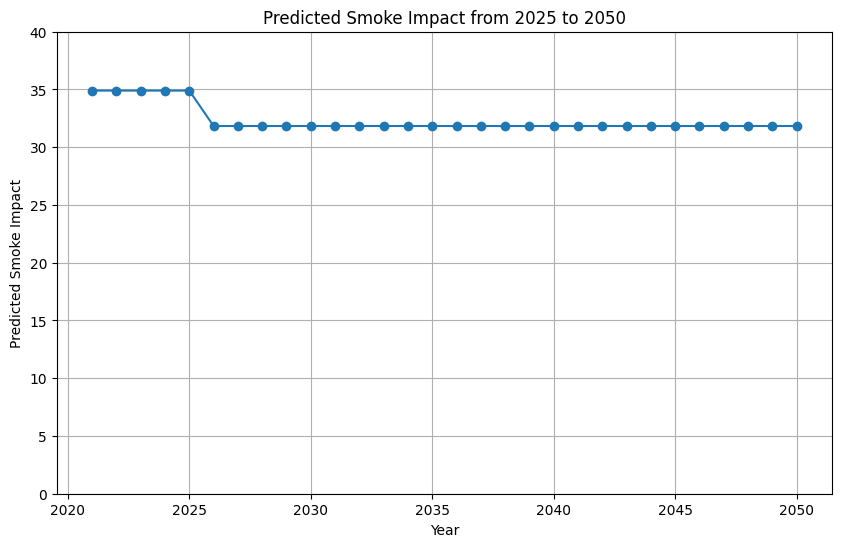

In [142]:
# Plot predicted smoke impact
plt.figure(figsize=(10, 6))
plt.plot(future_predictions['year'], future_predictions['predicted_smoke_impact'], label='Predicted Smoke Impact', linestyle='-', marker='o')

# Add titles and labels
plt.title('Predicted Smoke Impact from 2025 to 2050')
plt.xlabel('Year')
plt.ylabel('Predicted Smoke Impact')
plt.ylim(0, 40)  # Set y-axis to start at 0
plt.grid(True)

# Display the plot
plt.show()
